## Here we try to extract the MGRS (Military Grid Reference System) Coordinates from the svg element.

We assume that the coordinates are created through path elements and display complex polygons as text. So we think the coordinates are just svg path elements with very long d attributes (between 3000 and 6000). After we found them we also try to reengineer the position of the element from the original svg. Therefore we look at the svg transformation from the parent elements of the specific path element which might be the coordinates. 

In the end we create a little png from the isolated svg path element and do OCR to get the Text machine readable from the svg path element. 

In [3]:
from bs4 import BeautifulSoup
import cairosvg
import pytesseract
from PIL import Image

In [30]:
def calculate_coordinates(path):
    parent = path.parent

    start_coordinates_path_element = ()

    while parent:
        print("Parent Element:", parent.name)
        for attribute, value in parent.attrs.items():

            if attribute == "transform":
                
                print(f"{attribute}: {value}")
                # here we extract the start coordinate information  for the path element out of the transform attributes from the svg parent elements
                transformations = value.split("(")[-1].split(")")[0].split(",")
                # if attribute transform has 1 or 2 elements its just a relocation (the function translate) of the coordinates in either x or x and y direction
                # if attribute transform has 6 elements its the function matrix. Here is what each position does:
                # 1. scaling x coordinates
                # 2. skewing transformation alongside x axis
                # 3. skewing transformation alongside y axis
                # 4. scaling y coordinates 
                # 5. translation in x direction
                # 6. translation in y direction

                if len(transformations) == 2:
                    start_coordinates_path_element = (float(transformations[0]), float(transformations[1]))
            
                elif len(transformations) == 1:
                    start_coordinates_path_element = (start_coordinates_path_element[0] + float(transformations[0]) , start_coordinates_path_element[1])

                elif len(transformations) == 6:

                    #1. scaling x coordinates
                    start_coordinates_path_element =  (start_coordinates_path_element[0] * float(transformations[0]), start_coordinates_path_element[1])

                    #4. scaling y coordinates and 6. translate in y directio 
                    start_coordinates_path_element = (start_coordinates_path_element[0], (float(transformations[3]) * start_coordinates_path_element[1]) + float(transformations[5]) )


                print("neu berechnete Koordinaten: ")
                print(start_coordinates_path_element)
        
        parent = parent.parent
    print("Endgültige Startkoordinatne für path Element: ")
    print(start_coordinates_path_element)
    return start_coordinates_path_element

In [3]:
def find_mgrs_coordinates(pdf):
    # Open and read the SVG file
    with open(pdf, 'r') as file:
        svg_content = file.read()

    file_id = pdf.split(".")[0].split("/")[-1]

    # Parse the SVG content using BeautifulSoup with lxml's XML parser
    soup = BeautifulSoup(svg_content, 'xml')
    min_length = 2000
    max_length = 6000

    svg_elements = []

    for path in soup.find_all('path'):
        d_length = len(path.get('d', ''))  # Get the length of the `d` attribute
        if min_length <= d_length <= max_length:
            svg_elements.append(path)


    #military grid reference system
    mgrs_coordinates = []

    count_coordinate = 0
    # Output the paths or manipulate them as needed
    for path in svg_elements:
        count_coordinate += 1 # count how many coordinates appear in the pdf

        print(path)
        print("Length of 'd' attribute:", len(path['d']))
        # Traverse up the tree to print parent elements and their attributes

        start_coordinates_path_element = calculate_coordinates(path)
        
        #now we manipulate the svg path element in a way that we can create a picture out of it for OCR

        svg_drawing = "<" + (str(path).split("/>")[0] + ' transform="scale(1, -1) translate(0, -10)"' + "/>").split("svg:")[-1] 
        svg_drawing = '<svg xmlns="http://www.w3.org/2000/svg" width="80" height="20">' + svg_drawing + '</svg>'

        name = file_id + "_num_" + str(count_coordinate)

        mgrs_coordinates.append({"path" : path, "coordinates": start_coordinates_path_element, "svg_drawing": svg_drawing, "file_id": name})
    return mgrs_coordinates


In [32]:
coordinates = find_mgrs_coordinates("data/2583-II.svg")

<svg:path d="m 0,0 h 0.96 c 0.48,-0.96 0.48,-1.44 0.96,-1.44 0.48,-0.48 0.48,-0.48 0.96,-0.48 0.96,0 1.44,0 1.92,0.48 0,0.48 0.48,0.96 0.48,1.44 0,0.48 -0.48,0.96 -0.48,1.44 -0.48,0.48 -0.96,0.48 -1.44,0.48 -0.48,0 -0.48,0 -0.96,0 v 0.96 c 0,0 0,0 0.48,0 0.48,0 0.96,0.48 1.44,0.48 0,0.48 0.48,0.96 0.48,1.44 0,0.48 0,0.96 -0.48,0.96 C 3.84,6.24 3.36,6.24 2.88,6.24 2.4,6.24 2.4,6.24 1.92,5.76 1.44,5.76 1.44,5.28 1.44,4.32 L 0,4.8 C 0,5.28 0.48,6.24 0.96,6.72 1.44,7.2 2.4,7.2 2.88,7.2 c 0.48,0 1.44,0 1.92,-0.48 0,0 0.48,-0.48 0.96,-0.96 0,0 0,-0.48 0,-0.96 0,-0.48 0,-0.96 0,-1.44 C 5.28,3.36 5.28,2.88 4.8,2.4 5.28,2.4 5.76,2.4 5.76,1.92 6.24,1.44 6.72,0.96 6.72,0 6.72,-0.96 6.24,-1.44 5.76,-1.92 4.8,-2.88 3.84,-2.88 2.88,-2.88 2.4,-2.88 1.44,-2.88 0.96,-2.4 0.48,-1.92 0,-0.96 0,0 Z m 7.68,0 h 1.44 c 0,-0.96 0.48,-1.44 0.48,-1.44 0.48,-0.48 0.96,-0.48 1.44,-0.48 0.48,0 0.96,0 1.44,0.48 0.48,0.48 0.48,0.96 0.48,1.44 0,0.48 0,0.96 -0.48,1.44 -0.48,0.48 -0.96,0.48 -1.44,0.48 0,0 -0.48,0 -0.96

In [33]:
coordinates[0]

{'path': <svg:path d="m 0,0 h 0.96 c 0.48,-0.96 0.48,-1.44 0.96,-1.44 0.48,-0.48 0.48,-0.48 0.96,-0.48 0.96,0 1.44,0 1.92,0.48 0,0.48 0.48,0.96 0.48,1.44 0,0.48 -0.48,0.96 -0.48,1.44 -0.48,0.48 -0.96,0.48 -1.44,0.48 -0.48,0 -0.48,0 -0.96,0 v 0.96 c 0,0 0,0 0.48,0 0.48,0 0.96,0.48 1.44,0.48 0,0.48 0.48,0.96 0.48,1.44 0,0.48 0,0.96 -0.48,0.96 C 3.84,6.24 3.36,6.24 2.88,6.24 2.4,6.24 2.4,6.24 1.92,5.76 1.44,5.76 1.44,5.28 1.44,4.32 L 0,4.8 C 0,5.28 0.48,6.24 0.96,6.72 1.44,7.2 2.4,7.2 2.88,7.2 c 0.48,0 1.44,0 1.92,-0.48 0,0 0.48,-0.48 0.96,-0.96 0,0 0,-0.48 0,-0.96 0,-0.48 0,-0.96 0,-1.44 C 5.28,3.36 5.28,2.88 4.8,2.4 5.28,2.4 5.76,2.4 5.76,1.92 6.24,1.44 6.72,0.96 6.72,0 6.72,-0.96 6.24,-1.44 5.76,-1.92 4.8,-2.88 3.84,-2.88 2.88,-2.88 2.4,-2.88 1.44,-2.88 0.96,-2.4 0.48,-1.92 0,-0.96 0,0 Z m 7.68,0 h 1.44 c 0,-0.96 0.48,-1.44 0.48,-1.44 0.48,-0.48 0.96,-0.48 1.44,-0.48 0.48,0 0.96,0 1.44,0.48 0.48,0.48 0.48,0.96 0.48,1.44 0,0.48 0,0.96 -0.48,1.44 -0.48,0.48 -0.96,0.48 -1.44,0.48 0,0 -0.4

# Now we create a picture of the svg path element to prepare for OCR

In [6]:
# 1. we create an svg image from the coordinate
# 2. convert the svg to png
# 3. ocr on the png
# 4. return coordinates as text

def ocr_image(svg_path, file_id):
    # Open the file in write mode and write the SVG content
    with open(f"data/ocr_images/{file_id}.svg", 'w') as file:
        file.write(svg_path)

    # Convert SVG to PNG
    cairosvg.svg2png(url = f"data/ocr_images/{file_id}.svg", write_to=f"data/ocr_images/{file_id}.png")

    img = Image.open(f"data/ocr_images/{file_id}.png")
    # Use Tesseract to do OCR on the image
    text = pytesseract.image_to_string(img)
    return text.strip()
    

In [7]:
ocr_image(coordinates[1]["svg_drawing"], coordinates[1]["file_id"])

'33TWK8769'

In [8]:
import mgrs

def convert_mgrs_to_latlon(mgrs_str):
    m = mgrs.MGRS()
    # Convert MGRS string to latitude and longitude
    latlon = m.toLatLon(mgrs_str.encode('utf-8'))
    return latlon

# Example MGRS coordinate
mgrs_coordinate = "34TBP8932"
latlon = convert_mgrs_to_latlon(mgrs_coordinate)
print(f"{latlon[0]}, {latlon[1]}")

43.61108109713452, 18.38529256651145


## find all used colors

In [9]:
from bs4 import BeautifulSoup


def find_all_used_colors(pdf):
    # Open and read the SVG file
    with open(pdf, 'r') as file:
        svg_content = file.read()

    soup = BeautifulSoup(svg_content, 'xml')  # Use 'xml' parser for parsing SVG


    unique_colors = set()  # Set to store unique colors

    for path in soup.find_all('path'):
        style = path.get('style')  # Get the style attribute of the path
        if style:
            styles = style.split(';')  # Split style into individual properties
            fill_style = [s for s in styles if 'fill:' in s]  # Find the fill style
            if fill_style:
                color = fill_style[0].split(':')[1].strip()  # Extract the color value
                unique_colors.add(color)  # Add to set of unique colors

    # Output the unique colors
    return unique_colors


In [40]:
find_all_used_colors("./data/2583-II.svg")

{'#000000', '#00ff00', '#00ffff', '#ff0000', '#ffff00', '#ffffff', 'none'}

## find yellow cross element

In [37]:



def find_cross_coordinates(svg):
    
    with open(svg, 'r') as file:
        svg_content = file.read()
  
    soup = BeautifulSoup(svg_content, 'xml')

    file_id = svg.strip("/")[-1]

    target_color = '#ffff00'
    paths_with_target_color = []

    for path in soup.find_all('path'):
        # Check within the style attribute
        if path.get('style'):
            styles = dict(item.split(':') for item in path['style'].split(';') if item)
            if 'fill' in styles and styles['fill'].strip() == target_color:
                if len(path.get('d', '')) == 63: # here we filter out the yellow crosses because they have a length of 63
                    paths_with_target_color.append(path)
                    print(path)

    assert len(paths_with_target_color) == 2, f"In {file_id} are no, only one or too many yellow crosses"

    # To get the center of the cross one has to add 4.56 in y direction because the drawing start at the bottom.

    coordinates = []

    for path in paths_with_target_color:

        coord = calculate_coordinates(path)

        coord = (coord[0], coord[1] - 7)

        coordinates.append(coord)

    return coordinates

In [39]:
find_cross_coordinates("./data/2581-II.svg")

<svg:path d="M 0,0 V 4.32 H -4.8 V 4.8 H 0 v 4.32 0 V 4.8 H 4.8 V 4.32 H 0 Z" id="path9322" style="fill:#ffff00;fill-opacity:1;fill-rule:nonzero;stroke:none"/>
<svg:path d="M 0,0 V 4.32 H -4.8 V 4.8 H 0 v 4.32 0 V 4.8 H 4.8 V 4.32 H 0 Z" id="path9334" style="fill:#ffff00;fill-opacity:1;fill-rule:nonzero;stroke:none"/>
Parent Element: g
transform: translate(504.48,979.68)
neu berechnete Koordinaten: 
(504.48, 979.68)
Parent Element: g
transform: translate(16.8)
neu berechnete Koordinaten: 
(521.28, 979.68)
Parent Element: g
transform: matrix(1.3333333,0,0,-1.3333333,0,2781.7333)
neu berechnete Koordinaten: 
(695.039982624, 1475.493332656)
Parent Element: svg
Parent Element: [document]
Endgültige Startkoordinatne für path Element: 
(695.039982624, 1475.493332656)
Parent Element: g
transform: translate(900,969.12)
neu berechnete Koordinaten: 
(900.0, 969.12)
Parent Element: g
transform: translate(16.8)
neu berechnete Koordinaten: 
(916.8, 969.12)
Parent Element: g
transform: matrix(1.3333

[(695.039982624, 1468.493332656), (1222.39996944, 1482.573332304)]

# Find svg elements by color


In [41]:
def find_element_by_color(svg):
    #00ff00 green

    with open(svg, 'r') as file:
        svg_content = file.read()
  
    soup = BeautifulSoup(svg_content, 'xml')

    target_color = '#00ff00'
    elements_with_target_color = []

    # Loop through all SVG elements
    for element in soup.find_all(True):
        # Check within the style attribute
        if element.get('style'):
            styles = dict(item.split(':') for item in element['style'].split(';') if item)
            if 'fill' in styles and styles['fill'].strip() == target_color:
                elements_with_target_color.append(element)

    # Print the matching elements
    for elem in elements_with_target_color:
        print(elem)

In [42]:
find_element_by_color("./data/2583-II.svg")soup = BeautifulSoup(svg_content, 'html.parser')

# Find all path elements
path_elements = soup.find_all('path')

# Filter path elements with black stroke color
black_paths = [path for path in path_elements if 'stroke:#000000' in path.get('style', '')]

# Print the result
for path in black_paths:
    print(path)

<svg:path d="M 0,0 1.92,1.92 3.84,0 1.92,-1.92 Z" id="path9702" style="fill:#00ff00;fill-opacity:1;fill-rule:evenodd;stroke:none"/>
<svg:path d="M 0,0 1.92,1.92 3.84,0 1.92,-1.92 Z" id="path9726" style="fill:#00ff00;fill-opacity:1;fill-rule:evenodd;stroke:none"/>
<svg:path d="M 0,0 1.92,1.92 3.84,0 1.92,-1.92 Z" id="path9774" style="fill:#00ff00;fill-opacity:1;fill-rule:evenodd;stroke:none"/>
<svg:path d="M 0,0 1.92,1.92 3.84,0 1.92,-1.92 Z" id="path9798" style="fill:#00ff00;fill-opacity:1;fill-rule:evenodd;stroke:none"/>
<svg:path d="m 0,0 c 0.48,0 0.96,-0.48 1.44,-0.96 0.48,0 0.48,-0.96 0.48,-1.44 0,-0.48 0,-0.96 -0.48,-1.44 C 0.96,-4.32 0.48,-4.8 0,-4.8 c -0.48,0 -1.44,0.48 -1.44,0.96 -0.48,0.48 -0.96,0.96 -0.96,1.44 0,0.48 0.48,1.44 0.96,1.44 C -1.44,-0.48 -0.48,0 0,0 Z m 0,0.96 c -0.48,0 -0.96,0 -1.44,0 -0.48,0 -0.96,-0.48 -0.96,-0.96 -0.48,0 -0.96,-0.48 -0.96,-0.96 0,-0.48 0,-0.96 0,-1.44 0,-0.48 0,-0.96 0,-1.44 0,-0.48 0.48,-0.48 0.96,-0.96 0,-0.48 0.48,-0.48 0.96,-0.96 0.48,0 0

In [16]:
def extract_number(s):
    return int(''.join([c for c in s if c.isdigit()]))

In [162]:

from svgpathtools import parse_path
from svgpathtools import Path, Line
import math

def extract_number(string):
    """Helper function to extract the first number from a string."""
    return int(''.join(filter(str.isdigit, string)))

def compare_tuples(tuple1, tuple2, rel_tol=1e-4, abs_tol=1e-6):
    return (math.isclose(tuple1[0], tuple2[0], rel_tol=rel_tol, abs_tol=abs_tol) and
            math.isclose(tuple1[1], tuple2[1], rel_tol=rel_tol, abs_tol=abs_tol))


def apply_svg_path_to_coordinate(path_str: str, coord: tuple) -> tuple:

    print(path_str)
    # Function which applies path manipulations from d element to coordinates (x,y)
    path = parse_path(path_str)
    x, y = coord

    # Initial point
    current_point = complex(x, y)

    for segment in path:
        if isinstance(segment, Line):
            end_point = current_point + (segment.end - segment.start)
            current_point = end_point
        else:
            raise NotImplementedError("Only line segments are implemented in this example.")
    
    return current_point.real, current_point.imag


def find_suspect_areas(svg):
    from bs4 import BeautifulSoup

    with open(svg, 'r') as file:
        svg_content = file.read()
  
    soup = BeautifulSoup(svg_content, 'xml')

    # Find all path elements
    path_elements = soup.find_all('path')

    # Filter path elements with black stroke color
    black_paths = [path for path in path_elements if 'stroke:#000000' in path.get('style', '') and 'stroke-width:3.84' in path.get('style', '')]

    # Print the result
    suspect_areas = []
    current_group = []

    for path in black_paths:
        
        length_d = len(path.get('d', ''))

        if length_d >= 8 and length_d <= 25:
            if len(current_group) == 0:
                current_group.append(path)
            else:
                current_id = extract_number(path.get("id", ""))
                previous_id = extract_number(current_group[-1].get("id", ""))

                current_coords = path.parent.get("transform", "").split("(")[-1].split(")")[0].split(",")
                current_coords = (float(current_coords[0]), float(current_coords[1]))

                previous_coords = current_group[-1].parent.get("transform", "").split("(")[-1].split(")")[0].split(",")
                previous_coords = (float(previous_coords[0]), float(previous_coords[1]))

                check_coords = apply_svg_path_to_coordinate(current_group[-1].get("d", ""), previous_coords)

                #print(previous_coords, check_coords, current_coords)

                if (current_id - previous_id) == 6 and compare_tuples(check_coords, current_coords):
                    current_group.append(path)
                else:
                    suspect_areas.append(current_group)
                    current_group = [path]
        else:
            if current_group:
                suspect_areas.append(current_group)
                current_group = []

    if current_group:
        suspect_areas.append(current_group)


      # Apply calculate_coordinates() to each path in suspect_areas

    
    suspect_areas_with_coordinates = [
        [calculate_coordinates(path) for path in group]
        for group in suspect_areas
    ]
        
    for item in suspect_areas_with_coordinates:
        print(item)

  
    #check in 2385-II.svg for polygon artifacts
    for item in suspect_areas[19]:
        print(item)
        print(calculate_coordinates(item))

    
        
    return suspect_areas_with_coordinates



In [165]:
polygons = find_suspect_areas("data/2384-I.svg")

M 0,0 -13.44,-2.4
M 0,0 2.88,-0.48
M 0,0 H 2.4
M 0,0 1.44,2.4
M 0,0 1.92,0.96
M 0,0 V 2.4
M 0,0 2.4,0.48
M 0,0 -7.2,8.16
M 0,0 -0.48,-0.96
M 0,0 -1.92,-2.4
M 0,0 -2.4,-1.44
M 0,0 -1.44,-1.92
M 0,0 -1.92,-2.4
M 0,0 -0.48,-2.4
M 0,0 V -2.4
M 0,0 0.96,-0.96
M 0,0 1.44,-0.96
M 0,0 2.4,-1.44
M 0,0 0.96,-0.48
M 0,0 0.96,-0.96
M 0,0 1.44,-3.36
M 0,0 2.88,-1.92
M 0,0 1.44,-1.92
M 0,0 V -0.96
M 0,0 V -1.44
M 0,0 0.48,-1.44
M 0,0 0.48,-0.48
M 0,0 0.48,-0.48
M 0,0 0.48,-0.48
M 0,0 -1.92,-0.96
M 0,0 -0.96,-0.96
M 0,0 -1.44,-0.96
M 0,0 -1.44,-0.96
M 0,0 -1.44,-1.44
M 0,0 -7.2,8.16
M 0,0 -13.44,-2.4
M 0,0 2.88,-0.48
M 0,0 0.96,-7.68
M 0,0 9.12,-2.4
M 0,0 2.88,-0.96
M 0,0 1.44,0.48
M 0,0 5.28,1.44
M 0,0 -5.28,-11.04
M 0,0 -5.28,1.44
M 0,0 -1.92,0.96
M 0,0 -3.84,2.88
M 0,0 0.96,0.96
M 0,0 1.44,0.96
M 0,0 1.44,0.96
M 0,0 0.96,0.96
M 0,0 1.44,0.48
M 0,0 0.48,0.48
M 0,0 4.8,-1.44
M 0,0 10.56,-1.44
M 0,0 10.56,-1.44
M 0,0 0.48,-6.72
M 0,0 -7.68,-6.72
M 0,0 -2.88,-3.36
M 0,0 -6.72,0.96
M 0,0 1.44,-12
M 0,0

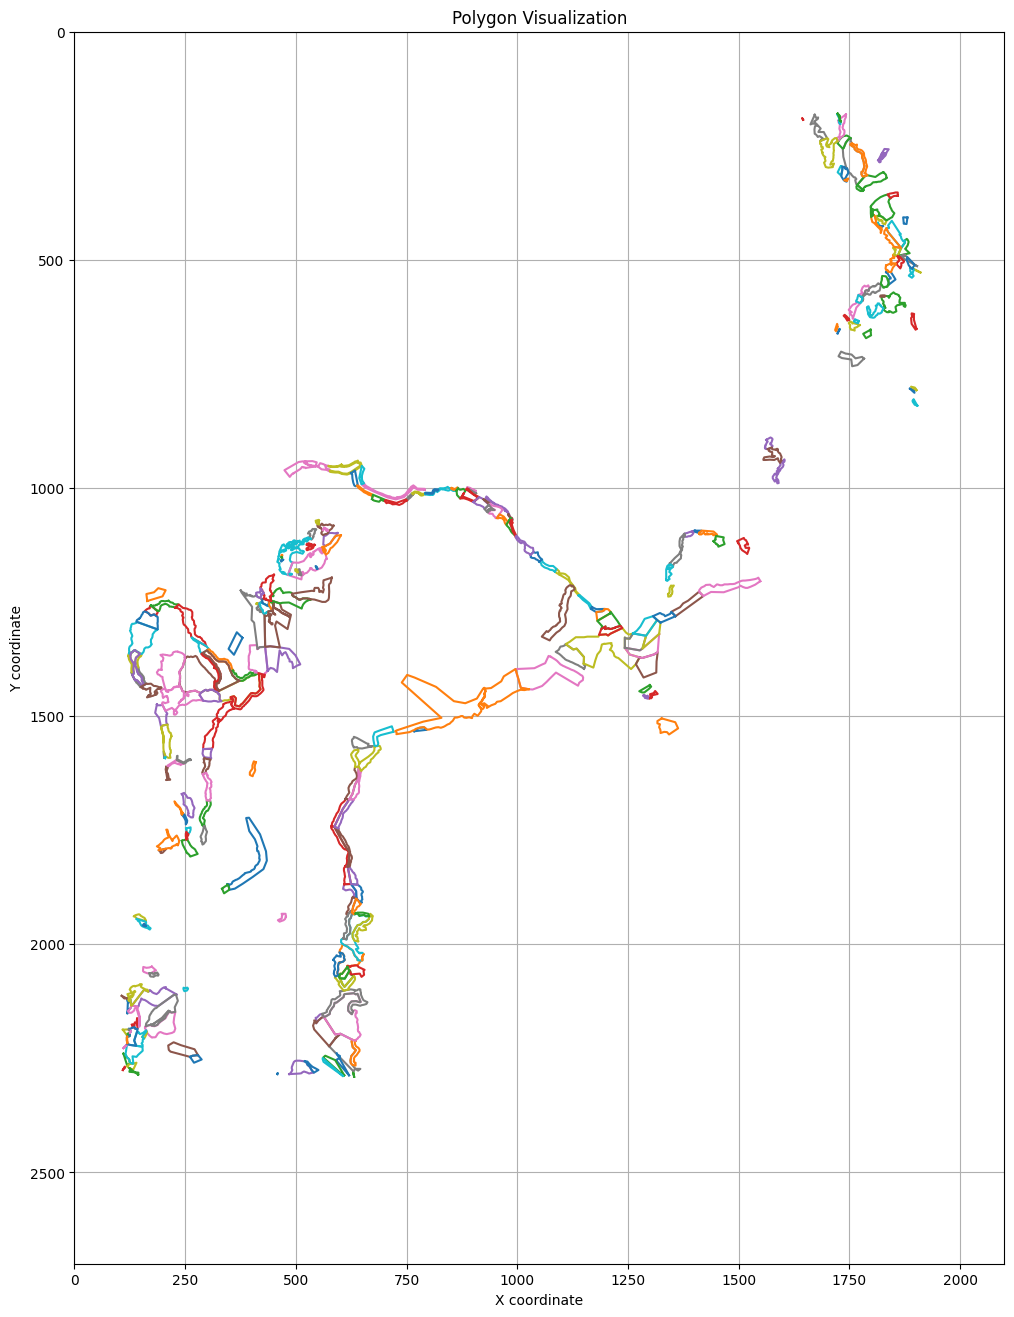

In [166]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


fig, ax = plt.subplots(figsize=(12, 16))  # Adjust the size as needed


# Plot each polygon
for polygon in polygons:
    polygon.append(polygon[0])  # Close the polygon by adding the first point at the end
    xs, ys = zip(*polygon)  # Extract x and y coordinates
    ax.plot(xs, ys)

# Set the axis limits based on the dimensions
ax.set_xlim(0, 2100)
ax.set_ylim(2700, 0)  # Invert the y-axis


# Add grid for better visualization
ax.grid(True)

# Add labels
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('Polygon Visualization')

# Show the plot
plt.show()